In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch

In [ ]:
gait_indices = 0
frequencies = 3.
phase = 0.5
offsets = 0
bounds = 0
durations = 0.5
kappa = 0.7
dt = 0.002

In [ ]:
smoothing_cdf_start = torch.distributions.normal.Normal(0,kappa).cdf
gait_indices = torch.zeros(1, dtype = torch.float, device = 'cpu', requires_grad= False)


In [ ]:
time_dt = []
desired_FL = []
desired_FR = []
desired_RL = []
desired_RR = []
for i in range(500):
    time_dt.append(dt)
    dt += 0.002
    gait_indices = torch.remainder(gait_indices + dt * frequencies, 1.0)
    foot_indices = [gait_indices,
                    torch.remainder(gait_indices + phase, 1.0),
                    torch.remainder(gait_indices + phase, 1.0),
                    gait_indices]

    for idxs in foot_indices:
        stance_idxs = torch.remainder(idxs, 1) < durations
        swing_idxs = torch.remainder(idxs, 1) > durations
        
        idxs[stance_idxs] = torch.remainder(idxs[stance_idxs], 1) 
        idxs[swing_idxs] = 0.5 + (torch.remainder(idxs[swing_idxs], 1) - 0.5) * (
                    0.5 / (1 - 0.5))
        
    smoothing_multiplier_FL = (smoothing_cdf_start(torch.remainder(foot_indices[0], 1.0)) * (
                    1 - smoothing_cdf_start(torch.remainder(foot_indices[0], 1.0) - 0.5)) +
                                       smoothing_cdf_start(torch.remainder(foot_indices[0], 1.0) - 1) * (
                                               1 - smoothing_cdf_start(
                                           torch.remainder(foot_indices[0], 1.0) - 0.5 - 1)))
    desired_FL.append(smoothing_multiplier_FL)
    smoothing_multiplier_FR = (smoothing_cdf_start(torch.remainder(foot_indices[1], 1.0)) * (
                    1 - smoothing_cdf_start(torch.remainder(foot_indices[1], 1.0) - 0.5)) +
                                       smoothing_cdf_start(torch.remainder(foot_indices[1], 1.0) - 1) * (
                                               1 - smoothing_cdf_start(
                                           torch.remainder(foot_indices[1], 1.0) - 0.5 - 1)))
    desired_FR.append(smoothing_multiplier_FR)
    smoothing_multiplier_RL = (smoothing_cdf_start(torch.remainder(foot_indices[2], 1.0)) * (
                    1 - smoothing_cdf_start(torch.remainder(foot_indices[2], 1.0) - 0.5)) +
                                       smoothing_cdf_start(torch.remainder(foot_indices[2], 1.0) - 1) * (
                                               1 - smoothing_cdf_start(
                                           torch.remainder(foot_indices[2], 1.0) - 0.5 - 1)))
    desired_RL.append(smoothing_multiplier_RL)
    smoothing_multiplier_RR = (smoothing_cdf_start(torch.remainder(foot_indices[3], 1.0)) * (
                    1 - smoothing_cdf_start(torch.remainder(foot_indices[3], 1.0) - 0.5)) +
                                       smoothing_cdf_start(torch.remainder(foot_indices[3], 1.0) - 1) * (
                                               1 - smoothing_cdf_start(
                                           torch.remainder(foot_indices[3], 1.0) - 0.5 - 1)))
    desired_RR.append(smoothing_multiplier_RR)    

In [ ]:
desired_FL_plot = [t.item() for t in desired_FL]
desired_FR_plot = [t.item() for t in desired_FR]
desired_RL_plot = [t.item() for t in desired_RL]
desired_RR_plot = [t.item() for t in desired_RR]

In [ ]:
n_rows, n_cols = 4,1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 8))

axs[0].plot(time_dt, desired_FL_plot, marker='o')
axs[0].set_title('Desired FL Plot')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')

axs[1].plot(time_dt, desired_FR_plot, marker='o')
axs[1].set_title('Desired FR Plot')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value')

axs[2].plot(time_dt, desired_RL_plot, marker='o')
axs[2].set_title('Desired RL Plot')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Value')

axs[3].plot(time_dt, desired_RR_plot, marker='o')
axs[3].set_title('Desired RR Plot')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [4]:
phase_diffs = torch.tensor([0.0, 0.5, 0.0, 0.5], dtype=torch.float)
desired_FL, desired_FR, desired_RL, desired_RR = ([] for _ in range(4))
time_dt = []

for i in range(1000):
    time_dt.append(dt)
    dt += 0.002
    gait_indices = torch.remainder(gait_indices + dt * frequencies, 1.0)
    
    # Correcting the calculation of foot_indices to model each foot's phase in the gait cycle
    foot_indices = [gait_indices + phase,  # FL
                    gait_indices,          # FR
                    gait_indices + phase,  # RL (assuming a mirrored phase to FL for simplicity)
                    gait_indices]          # RR (assuming a mirrored phase to FR for simplicity)

    # Iterate over each foot's indices to calculate stance/swing and apply smoothing
    for j, idxs in enumerate(foot_indices):
        # Calculate stance and swing indices based on durations
        stance_idxs = torch.remainder(idxs, 1) < durations
        swing_idxs = torch.remainder(idxs, 1) >= durations
        
        # Apply the swing/stance logic (simplified for explanation)
        # This can be further refined based on your specific model's needs
        smoothing_multiplier = smoothing_cdf_start(torch.remainder(idxs, 1.0)) * \
                               (1 - smoothing_cdf_start(torch.remainder(idxs, 1.0) - durations)) + \
                               smoothing_cdf_start(torch.remainder(idxs, 1.0) - 1) * \
                               (1 - smoothing_cdf_start(torch.remainder(idxs, 1.0) - durations - 1))
        
        # Assigning the calculated smoothing_multiplier to the respective foot's list
        if j == 0: desired_FL.append(smoothing_multiplier)
        elif j == 1: desired_FR.append(smoothing_multiplier)
        elif j == 2: desired_RL.append(smoothing_multiplier)
        elif j == 3: desired_RR.append(smoothing_multiplier)

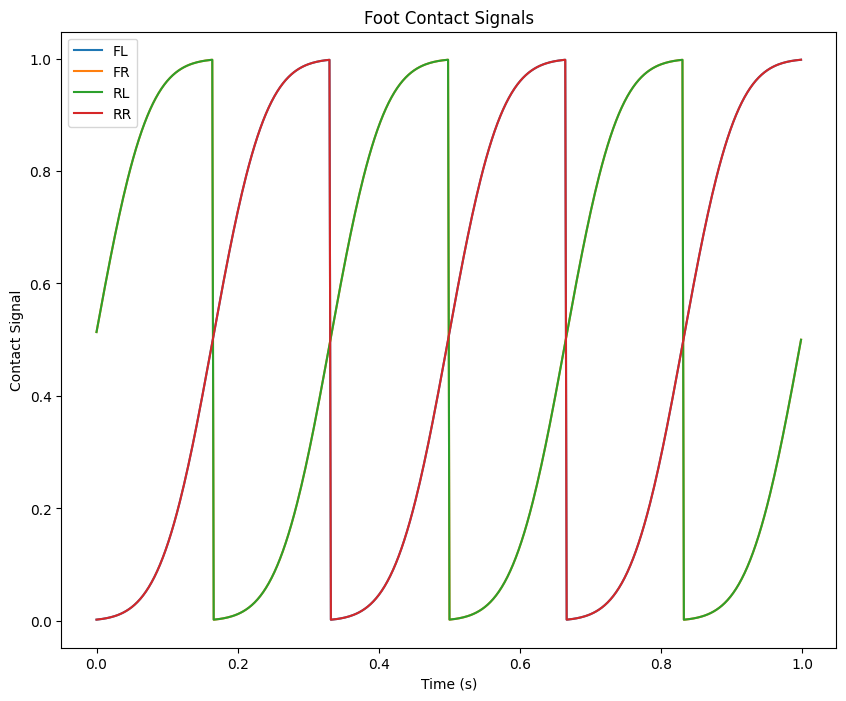

In [5]:
import torch
import matplotlib.pyplot as plt

# Initialize parameters
frequencies = 3.0
phase = 0.5
durations = 0.5
kappa = 0.7
dt_initial = 0.002
gait_indices = torch.zeros(1, dtype=torch.float, device='cpu', requires_grad=False)

# Define the smoothing function using a normal distribution's CDF
smoothing_cdf_start = torch.distributions.Normal(0, kappa).cdf

# Lists to hold time and desired contact signals for each foot
time_dt = []
desired_FL, desired_FR, desired_RL, desired_RR = [], [], [], []

for i in range(500):
    time_dt.append(i * dt_initial)
    gait_indices = torch.remainder(gait_indices + dt_initial * frequencies, 1.0)
    foot_indices = [gait_indices,
                    torch.remainder(gait_indices + phase, 1.0),
                    torch.remainder(gait_indices + phase, 1.0),
                    gait_indices]

    # Calculate the contact signal for each foot using the smoothing CDF
    for idx, foot_index in enumerate(foot_indices):
        # Map the foot index to a range suitable for the CDF (e.g., -2 to 2)
        mapped_index = (foot_index - 0.5) * 4  # Adjust this range as necessary
        contact_signal = smoothing_cdf_start(mapped_index)
        
        # Assign the calculated contact signal to the appropriate list
        if idx == 0:
            desired_FL.append(contact_signal)
        elif idx == 1:
            desired_FR.append(contact_signal)
        elif idx == 2:
            desired_RL.append(contact_signal)
        else:
            desired_RR.append(contact_signal)

# Convert lists to tensors for plotting
desired_FL = torch.tensor(desired_FL).squeeze()
desired_FR = torch.tensor(desired_FR).squeeze()
desired_RL = torch.tensor(desired_RL).squeeze()
desired_RR = torch.tensor(desired_RR).squeeze()

# Plotting the contact signals
plt.figure(figsize=(10, 8))
plt.plot(time_dt, desired_FL, label="FL")
plt.plot(time_dt, desired_FR, label="FR")
plt.plot(time_dt, desired_RL, label="RL")
plt.plot(time_dt, desired_RR, label="RR")
plt.title("Foot Contact Signals")
plt.xlabel("Time (s)")
plt.ylabel("Contact Signal")
plt.legend()
plt.show()


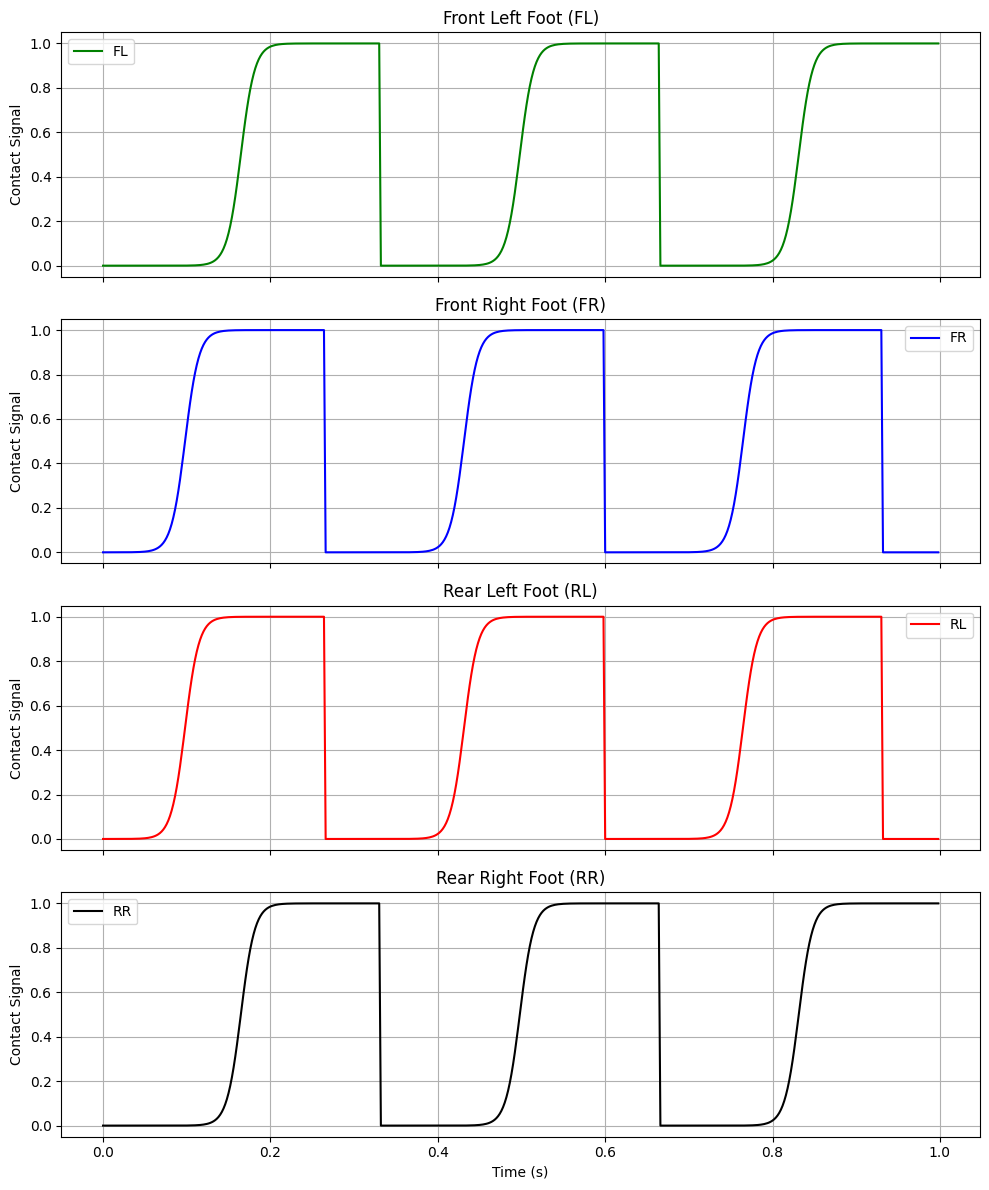

In [7]:
frequencies = 3.0
phase = 0.2
offsets = 0
bounds = 0
durations = 0.5
kappa = 40.
dt = 0.002

# Initialize variables
time_dt = []
desired_FL = []
desired_FR = []
desired_RL = []
desired_RR = []
gait_indices = torch.zeros(1, dtype=torch.float, device='cpu', requires_grad=False)

# Helper function to generate smooth contact signal using a sigmoid
def sigmoid_contact_signal(x, kappa):
    return 1 / (1 + torch.exp(-kappa * (x - 0.5)))

# Generating contact signals
for i in range(500):
    time_dt.append(i * dt)
    gait_indices = torch.remainder(gait_indices + dt * frequencies, 1.0)
    foot_indices = [gait_indices,
                    torch.remainder(gait_indices + phase, 1.0),
                    torch.remainder(gait_indices + phase + offsets, 1.0),
                    torch.remainder(gait_indices + offsets, 1.0)]

    # Calculate the contact signal for each foot using sigmoid
    desired_FL.append(sigmoid_contact_signal(foot_indices[0], kappa))
    desired_FR.append(sigmoid_contact_signal(foot_indices[1], kappa))
    desired_RL.append(sigmoid_contact_signal(foot_indices[2], kappa))
    desired_RR.append(sigmoid_contact_signal(foot_indices[3], kappa))

# Convert lists to tensors for plotting
# time_dt_tensor = torch.tensor(time_dt)
# desired_FL_tensor = torch.cat(desired_FL)
# desired_FR_tensor = torch.cat(desired_FR)
# desired_RL_tensor = torch.cat(desired_RL)
# desired_RR_tensor = torch.cat(desired_RR)

# # Plotting the contact signals
# plt.figure(figsize=(10, 8))
# plt.plot(time_dt_tensor.numpy(), desired_FL_tensor.numpy(), label="FL")
# plt.plot(time_dt_tensor.numpy(), desired_FR_tensor.numpy(), label="FR")
# plt.plot(time_dt_tensor.numpy(), desired_RL_tensor.numpy(), label="RL")
# plt.plot(time_dt_tensor.numpy(), desired_RR_tensor.numpy(), label="RR")
# plt.title("Foot Contact Signals for Cheetah's Periodic Trotting")
# plt.xlabel("Time (s)")
# plt.ylabel("Contact Signal")
# plt.legend()
# plt.show()
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
time_array = torch.tensor(time_dt)

axs[0].plot(time_array, torch.cat(desired_FL), 'g-', label="FL")
axs[0].set_title("Front Left Foot (FL)")
axs[0].legend()

axs[1].plot(time_array, torch.cat(desired_FR), 'b-', label="FR")
axs[1].set_title("Front Right Foot (FR)")
axs[1].legend()

axs[2].plot(time_array, torch.cat(desired_RL), 'r-', label="RL")
axs[2].set_title("Rear Left Foot (RL)")
axs[2].legend()

axs[3].plot(time_array, torch.cat(desired_RR), 'k-', label="RR")
axs[3].set_title("Rear Right Foot (RR)")
axs[3].legend()

for ax in axs:
    ax.set_ylabel("Contact Signal")
    ax.grid(True)
axs[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


In [ ]:
import torch
time_steps = 500
desired_FL_tensor = torch.sin(torch.linspace(0, 10, time_steps)) * 0.5 + 0.5
desired_FR_tensor = torch.sin(torch.linspace(0, 10, time_steps)) * 0.5 + 0.5
desired_RL_tensor = torch.sin(torch.linspace(0, 10, time_steps)) * 0.5 + 0.5
desired_RR_tensor = torch.sin(torch.linspace(0, 10, time_steps)) * 0.5 + 0.5

# Simulate actual binary signals based on a threshold
threshold = 0.5
actual_FL_example = (desired_FL_tensor > threshold).float()
actual_FR_example = (desired_FR_tensor > threshold).float()
actual_RL_example = (desired_RL_tensor > threshold).float()
actual_RR_example = (desired_RR_tensor > threshold).float()

# Define the custom loss function
def custom_loss(desired_signal, actual_signal):
    actual_signal = torch.round(actual_signal)  # Ensure this is binary
    overlap_loss = torch.sum(desired_signal * actual_signal)
    normalized_overlap_loss = 1.0 - (overlap_loss / torch.sum(desired_signal))
    return normalized_overlap_loss

# Calculating the custom loss for each foot using the example signals
loss_FL = custom_loss(desired_FL_tensor, actual_FL_example)
loss_FR = custom_loss(desired_FR_tensor, actual_FR_example)
loss_RL = custom_loss(desired_RL_tensor, actual_RL_example)
loss_RR = custom_loss(desired_RR_tensor, actual_RR_example)

loss_FL.item(), loss_FR.item(), loss_RL.item(), loss_RR.item()

In [ ]:
def _reward_tracking_contacts_shaped_force(desired_contact_states, contact_detect_self):
    desired_contact = desired_contact_states
    contact_detect = contact_detect_self
    contact_alignment_loss = torch.sum((contact_detect * (1-desired_contact))**2)
    non_contact_alignment_loss = torch.sum(((1 - contact_detect) * desired_contact)**2)
    total_loss = contact_alignment_loss + non_contact_alignment_loss
    normalized_loss = total_loss / contact_detect.numel()
    return normalized_loss